In [1]:
import numpy as np
import os
import argparse
from GridDataGen.utils.io import *
from GridDataGen.utils.process_network import *
from GridDataGen.utils.config import *
from GridDataGen.utils.stats import *
from GridDataGen.utils.param_handler import *
from GridDataGen.utils.load import *
from pandapower.auxiliary import pandapowerNet
import gc
from datetime import datetime
from tqdm import tqdm
from GridDataGen.utils.topology_perturbation import initialize_generator
import psutil
import shutil
import yaml
from GridDataGen.utils.process_network import process_scenario_contingency
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from pandapower.pypower.makeBdc import makeBdc
import pandapower as pp


/Users/albanpuech/grid_data_synthetic/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


# Functions to compute branch current

In [2]:
def compute_branch_currents_kA(Yf, Yt, V, Vf_base_kV, Vt_base_kV, sn_mva):

    
    If_pu = Yf @ V  # From-end currents in per-unit (I_f = Y_f V)
    If_kA = np.abs(If_pu) * sn_mva / (np.sqrt(3) * Vf_base_kV)  # Conversion to kA

    # Construct to-end admittance matrix Yt:
    # Yt[b, :] = y_tf_b * e_f + y_tt_b * e_t
    It_pu = Yt @ V  # To-end currents in per-unit (I_t = Y_t V)
    It_kA = np.abs(It_pu) * sn_mva / (np.sqrt(3) * Vt_base_kV)  # Conversion to kA


    return If_kA, It_kA


def compute_loading(If_kA, It_kA, Vf_base_kV, Vt_base_kV, rate_a):
    """
    Compute per-branch loading using current magnitudes and branch ratings.

    Parameters:
    - edge_index: np.ndarray of shape (n_edges, 2), each row is [from_bus, to_bus]
    - If_kA: np.ndarray of from-side current magnitudes in kA
    - It_kA: np.ndarray of to-side current magnitudes in kA
    - base_kv: np.ndarray of shape (n_buses,), base voltage in kV per bus
    - edge_attr: np.ndarray of shape (n_edges, >=5), edge features, column 4 = RATE_A

    Returns:
    - loading: np.ndarray of shape (n_edges,), max of from and to side loading
    """

    limitf = rate_a / (Vf_base_kV * np.sqrt(3))
    limitt = rate_a / (Vt_base_kV * np.sqrt(3))

    loadingf = If_kA / limitf
    loadingt = It_kA / limitt

    return np.maximum(loadingf, loadingt)




# Load data

In [6]:
# pf_node = pd.read_csv("../../data_contingency/case300_ieee/merged/GridFM_v0.1.2_case300_ieee_output_pf_node.csv")
pf_node= pd.read_csv("../../data_contingency/case300_ieee/raw/pf_node.csv")
branch_idx_removed = pd.read_csv("../../data_contingency/case300_ieee/raw/branch_idx_removed.csv")
edge_params = pd.read_csv("../../data_contingency/case300_ieee/raw/edge_params.csv")
bus_params = pd.read_csv("../../data_contingency/case300_ieee/raw/bus_params.csv")

# Sanity Check -> check the RMSE on voltage mag and angle make sense

In [9]:
pf_node["Va_dc"] -= (pf_node["Va_dc"] - pf_node["Va"]).mean()
# compute rmse on va_pred_corrected and va
rmse = np.sqrt(np.mean((pf_node["Va_dc"] - pf_node["Va"])**2))
print(f"RMSE: {rmse}")

# compute rmse on vm_pred_corrected and vm
rmse = np.sqrt(np.mean((pf_node["Vm_dc"] - pf_node["Vm"])**2))
print(f"RMSE: {rmse}")






RMSE: 2.8092289297340685
RMSE: 0.029034035202657384


# Create Admittance matrix

In [10]:
base_kv = bus_params["baseKV"].values
sn_mva = 100

# Extract from-bus and to-bus indices for each branch

f = edge_params["from_bus"].values.astype(np.int32)
t = edge_params["to_bus"].values.astype(np.int32)

# Extract branch admittance coefficients
Yff = edge_params["Yff_r"].values + 1j * edge_params["Yff_i"].values
Yft = edge_params["Yft_r"].values + 1j * edge_params["Yft_i"].values
Ytf = edge_params["Ytf_r"].values + 1j * edge_params["Ytf_i"].values
Ytt = edge_params["Ytt_r"].values + 1j * edge_params["Ytt_i"].values

# Get base voltages for the from and to buses (for kA conversion)
Vf_base_kV = base_kv[f]
Vt_base_kV = base_kv[t]

nl = edge_params.shape[0]
nb = bus_params.shape[0]

# i = [0, 1, ..., nl-1, 0, 1, ..., nl-1], used for constructing Yf and Yt
i = np.hstack([np.arange(nl), np.arange(nl)])

# Construct from-end admittance matrix Yf using the linear combination:
# Yf[b, :] = y_ff_b * e_f + y_ft_b * e_t
Yf = csr_matrix((np.hstack([Yff, Yft]), (i, np.hstack([f, t]))), shape=(nl, nb))
Yt = csr_matrix((np.hstack([Ytf, Ytt]), (i, np.hstack([f, t]))), shape=(nl, nb))



rate_a = edge_params["rate_a"].values

net = pp.networks.case300()
pp.rundcpp(net)
bus = net._ppc['bus']
branch = net._ppc["branch"]
Bbus, Bf, Pbusinj, Pfinj, Cft = makeBdc(bus, branch)
Bf = np.real(Bf)
Pfinj = np.real(Pfinj)

# Correct voltage predictions

In [19]:


pf_node["VM_dcpf_corrected"] = pf_node["Vm_dc"]
pf_node["VA_dcpf_corrected"] = pf_node["Va_dc"]


pf_node.loc[pf_node.PV==1, "VM_dcpf_corrected"] = pf_node.loc[pf_node.PV==1, "Vm"]
pf_node.loc[pf_node.REF==1, "VA_dcpf_corrected"] = pf_node.loc[pf_node.REF==1, "Va"]


In [20]:
# compute rmse on va_pred_corrected and va
rmse = np.sqrt(np.mean((pf_node["VA_dcpf_corrected"] - pf_node["Va"])**2))
print(f"RMSE: {rmse}")

# compute rmse on vm_pred_corrected and vm
rmse = np.sqrt(np.mean((pf_node["VM_dcpf_corrected"] - pf_node["Vm"])**2))
print(f"RMSE: {rmse}")






RMSE: 2.6667009572083873
RMSE: 0.028446287170877355


# Compute branch current and loading

In [21]:
loadings = []
loadings_pred = []
for scenario_idx in tqdm(pf_node.scenario.unique()):
    pf_node_scenario = pf_node[pf_node.scenario == scenario_idx]
    branch_idx_removed_scenario = branch_idx_removed[branch_idx_removed.scenario == scenario_idx].iloc[:, 1:].values
    # remove nan
    branch_idx_removed_scenario = branch_idx_removed_scenario[~np.isnan(branch_idx_removed_scenario)].astype(np.int32)
    V_true = pf_node_scenario["Vm"].values * np.exp(1j * pf_node_scenario["Va"].values * np.pi / 180)
    V_pred = pf_node_scenario["VM_dcpf_corrected"].values * np.exp(1j * pf_node_scenario["VA_dcpf_corrected"].values * np.pi / 180)
    If_true, It_true = compute_branch_currents_kA(Yf, Yt, V_true, Vf_base_kV, Vt_base_kV, sn_mva)
    If_pred, It_pred = compute_branch_currents_kA(Yf, Yt, V_pred, Vf_base_kV, Vt_base_kV, sn_mva)
    loading_true = compute_loading(If_true, It_true, Vf_base_kV, Vt_base_kV, rate_a)
    loading_pred = compute_loading(If_pred, It_pred, Vf_base_kV, Vt_base_kV, rate_a)
    # remove the branches that are removed from loading
    loading_true[branch_idx_removed_scenario] = -1
    loading_pred[branch_idx_removed_scenario] = -1
    loadings.append(loading_true)
    loadings_pred.append(loading_pred)

loadings = np.array(loadings)
loadings_pred = np.array(loadings_pred)
    

    

100%|██████████| 33999/33999 [02:56<00:00, 192.74it/s]


In [22]:
loadings = np.array(loadings)
loadings_pred = np.array(loadings_pred)


In [23]:
removed_lines = (loadings == -1)
removed_lines_pred = (loadings_pred == -1)

# assert the same lines are removed
assert (removed_lines == removed_lines_pred).all()

# assert the same number of lines are removed
assert (removed_lines.sum() == removed_lines_pred.sum())



# Compute overloadings

In [24]:
overloadings = loadings[removed_lines==False] > 1
overloadings_pred = (loadings_pred[removed_lines==False] > 0.95)


# Compute TPR, FPR, TNR, FNR

- Below are the results of DC PF for overloading classification
- Ground truth is AC PF.
- We use a threshold of 0.95 to make sure we identify all overloads

In [25]:
TPR = (overloadings & overloadings_pred).sum() / overloadings.sum()
FPR = ((~overloadings) & overloadings_pred).sum() / (~overloadings).sum()
TNR = ((~overloadings) & ~overloadings_pred).sum() / (~overloadings).sum()
FNR = (overloadings & ~overloadings_pred).sum() / overloadings.sum()

print(f"TPR: {TPR:.3f}, FPR: {FPR:.2f}, TNR: {TNR:.2f}, FNR: {FNR:.2f}")



TPR: 0.986, FPR: 0.01, TNR: 0.99, FNR: 0.01


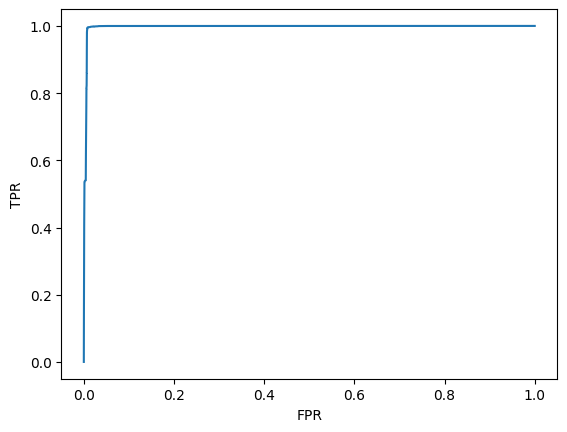

In [26]:
#ROC curve
# import roc curve
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(overloadings, loadings_pred[removed_lines==False])
plt.plot(fpr, tpr)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()


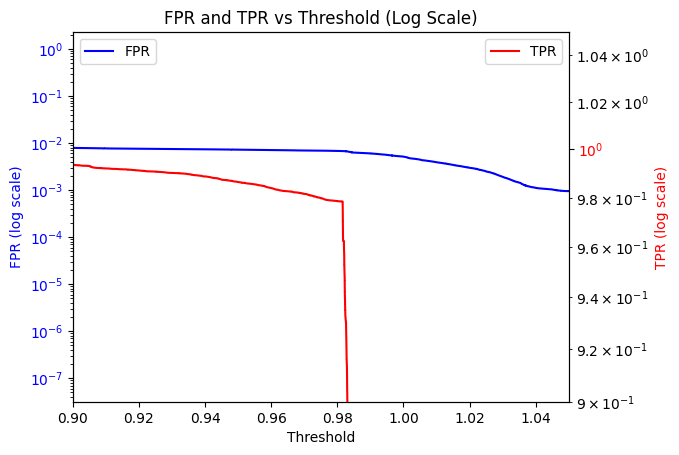

In [27]:
# Create DataFrame for FPR, TPR, and Threshold
fpr_tpr = pd.DataFrame({"FPR": fpr, "TPR": tpr, "Threshold": thresholds})

# Plot FPR on a log scale
fig, ax1 = plt.subplots()

ax1.plot(fpr_tpr["Threshold"], fpr_tpr["FPR"], label="FPR", color='blue')
ax1.set_xlabel("Threshold")
ax1.set_ylabel("FPR (log scale)", color='blue')
ax1.set_yscale('log')  # log scale for FPR
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_xlim(0.90, 1.05)



# Create a second y-axis for TPR
ax2 = ax1.twinx()
ax2.plot(fpr_tpr["Threshold"], fpr_tpr["TPR"], label="TPR", color='red')
ax2.set_ylabel("TPR (log scale)", color='red')
ax2.set_yscale('log')  # log scale for TPR
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylim(0.90, 1.05)

# Add legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.title("FPR and TPR vs Threshold (Log Scale)")
plt.show()

# Plot histogram of true loadings



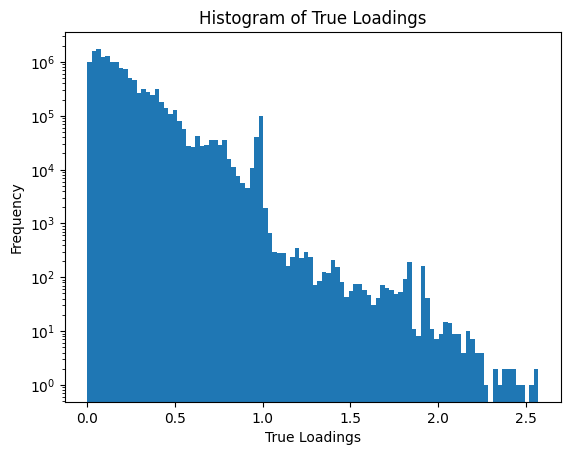

In [28]:
plt.hist(loadings[removed_lines==False], bins=100)
plt.xlabel("True Loadings")
plt.ylabel("Frequency")
plt.title("Histogram of True Loadings")
# log scale
plt.yscale('log')
os.makedirs("../../data_contingency/case300_ieee/plots", exist_ok=True)
plt.savefig("../../data_contingency/case300_ieee/plots/histogram_true_loadings.png")



# Plot pred vs true loadings

In [29]:
# create df from loadings
loadings_df = pd.DataFrame(loadings)
loadings_df.columns = [f"branch_{i}" for i in range(loadings_df.shape[1])]

loadings_pred_df = pd.DataFrame(loadings_pred)
loadings_pred_df.columns = [f"branch_{i}" for i in range(loadings_pred_df.shape[1])]




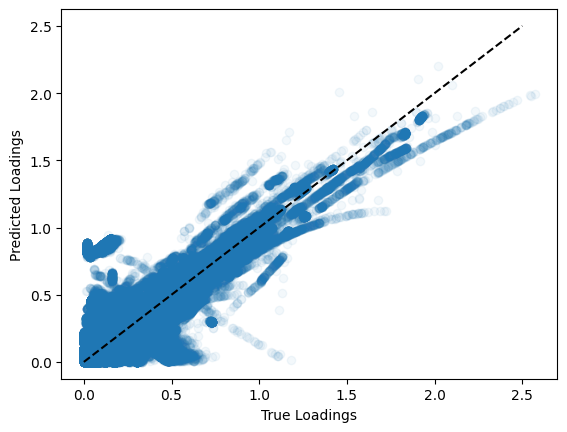

In [30]:
# scatter plot of loadings and loadings_pred
plt.scatter(loadings[removed_lines==False], loadings_pred[removed_lines==False], alpha=0.05)
plt.xlabel("True Loadings")
plt.ylabel("Predicted Loadings")
# plot the line y=x
plt.plot([0, 2.5], [0, 2.5], 'k--')
plt.show()



# Voltage violations

In [31]:
# merge bus_params["vmax"] and bus_params["vmin"] with pf_node on bus_idx
pf_node = pd.merge(pf_node, bus_params[["bus", "vmax", "vmin"]], on="bus", how="left")


- Below are the results of DC PF for voltage magnitude violations 
- Ground truth is AC PF.
- DC PF assumes voltages are equal to 1 at PQ buses hence it always predicts no violations

In [32]:
# check violations of vmax and vmin with VM_pred_corrected and Vm
voltage_violations = (pf_node["Vm"] > pf_node["vmax"]) | (pf_node["Vm"] < pf_node["vmin"])
voltage_violations_pred = (pf_node["VM_dcpf_corrected"] > pf_node["vmax"]-0.01) | (pf_node["VM_dcpf_corrected"] < pf_node["vmin"]+0.01)

# compute TPR, FPR, TNR, FNR
TPR = (voltage_violations & voltage_violations_pred).sum() / voltage_violations.sum()
FPR = (voltage_violations & (~voltage_violations_pred)).sum() / (~voltage_violations).sum()
TNR = (~voltage_violations & ~voltage_violations_pred).sum() / (~voltage_violations).sum()
FNR = (voltage_violations & (~voltage_violations_pred)).sum() / voltage_violations.sum()

print(f"TPR: {TPR:.2f}, FPR: {FPR:.2f}, TNR: {TNR:.2f}, FNR: {FNR:.2f}")

TPR: 0.07, FPR: 0.02, TNR: 0.90, FNR: 0.93


- DC PF assumes voltages are equal to 1 at PQ buses hence what we show on the plot below:

/Users/albanpuech/grid_data_synthetic/venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


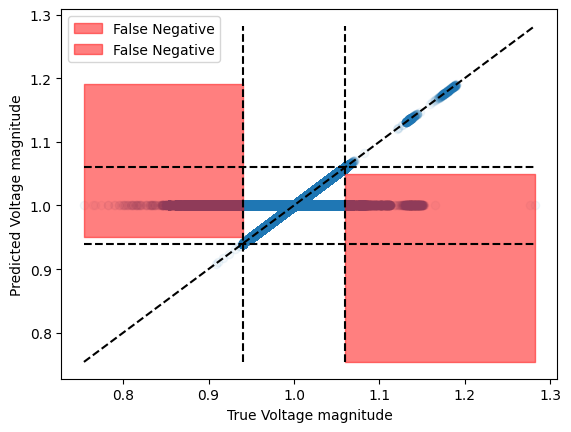

In [36]:
# scatter plot of va_pred_corrected and va
plt.scatter(pf_node["Vm"], pf_node["VM_dcpf_corrected"], alpha=0.05)
plt.xlabel("True Voltage magnitude")
plt.ylabel("Predicted Voltage magnitude")
# get max and min of pf_node["Vm"] and pf_node["VM_pred_corrected"]
max_vm = pf_node["Vm"].max()
min_vm = pf_node["Vm"].min()
max_vm_pred = pf_node["VM_dcpf_corrected"].max()
min_vm_pred = pf_node["VM_dcpf_corrected"].min()

# plot y=x
plt.plot([min_vm, max_vm], [min_vm, max_vm], 'k--')
# plot y = 0.94
plt.plot([min_vm, max_vm], [0.94, 0.94], 'k--')
plt.plot([min_vm, max_vm], [1.06, 1.06], 'k--')
# plot the line x = 0.94
plt.plot([0.94, 0.94], [min_vm, max_vm], 'k--')
# plot the line x = 1.06
plt.plot([1.06, 1.06], [min_vm, max_vm], 'k--')
# plot areas where x < 0.94 but y > 0.94
plt.fill_between([min_vm, 0.94], [0.95, 0.95], [max_vm_pred, max_vm_pred], color='red', alpha=0.5, label='False Negative')
# plot areas where x > 1.06 but y < 1.06
plt.fill_between([1.06, max_vm], [1.05, 1.05], [min_vm, min_vm], color='red', alpha=0.5, label='False Negative')

plt.legend()
plt.show()

